# VAERS Data Analysis
## Important Information About VAERS
* VAERS was created by FDA and CDC to receive reports about adverse events that may be associated with vaccenes. (Nov. 1, 1990 to today)
* VAERS is used to continually monitor reports to determine whether any vaccine or vaccine lot has a higher than expected rate of events.
* About 85-90% of vaccine adverse event reports concern relatively minor events, such as fevers or redness and swelling at the injection site. The remaining reports(less than 15%) describe serious events, such as hospitalizations, life-threatening illnesses, or deaths. 
* The adverse events described in each report were coded utilizing the FDA's Coding Symbols for a Thesaurus of Adverse Reaction Terms (COSTART) from November 1990 until 1/16/2007
* On 1/17/2007 the VAERS coding system was converted to an international coding system that is used worldwide. This system is called the Medical Dictionary for Regulatory Activities (MedDRA)
* There are two VAERS form, both versions are currently accepted:
 * VAERS 1 (before July 2017)
 * VAERS 2 (after July 2017)
* When multiple reports of a silgle case or event are received, only the first report received is included in the publicly acessible dataset.... 

## Description of Data Files
* Data sets files can be downloaded from [here](https://vaers.hhs.gov/data/datasets.html)
* There are three data files:
 * VAERSDATA.CSV
 * VAERSVAX.CSV
 * VAERSSYMPTOMS.CSV
* There are three data types:
 * NUM = numeric data
 * CHAR = text or "character" data
 * DATE = date fields in mm/dd/yy format
 
## VAERS Data Limitations

When evaluating data from VAERS, it is important to note that for any reported event, no cause-and-effect relationship has been established. Reports of all possible associations between vaccines and adverse events (possible side effects) are filed in VAERS. Therefore, VAERS collects data on any adverse event following vaccination, be it coincidental or truly caused by a vaccine. The report of an adverse event to VAERS is not documentation that a vaccine caused the event.

* VAERS is a passive reporting system, meaning that reports about adverse events are not automatically collected, but require a report to be filed to VAERS. VAERS reports can be submitted voluntarily by anyone, including healthcare providers, patients, or family members. Reports vary in quality and completeness. They often lack details and sometimes can have information that contains errors.
* "Underreporting" is one of the main limitations of passive surveillance systems, including VAERS. The term, underreporting refers to the fact that VAERS receives reports for only a small fraction of actual adverse events. The degree of underreporting varies widely. As an example, a great many of the millions of vaccinations administered each year by injection cause soreness, but relatively few of these episodes lead to a VAERS report. Physicians and patients understand that minor side effects of vaccinations often include this kind of discomfort, as well as low fevers. On the other hand, more serious and unexpected medical events are probably more likely to be reported than minor ones, especially when they occur soon after vaccination, even if they may be coincidental and related to other causes.
* A report to VAERS generally does not prove that the identified vaccine(s) caused the adverse event described. It only confirms that the reported event occurred sometime after vaccine was given. No proof that the event was caused by the vaccine is required in order for VAERS to accept the report. VAERS accepts all reports without judging whether the event was caused by the vaccine.

## STATE column are for the home state of the vaccinee. Foreign reports are in a separate data file(Non-Domestic)
 * STATE include all states and US territories like Puto Rico(PR), Guam(GU), etc.
 * The scope of this analysis is Domestic reports ONLY!

## Reference:
 * [VAERS Data Use Guide](https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf)
 * [MedDRA](https://www.meddra.org/) or [here](http://www.meddramsso.com)
 * [Guide to Interpreting VAERS Data](https://vaers.hhs.gov/data/dataguide.html)

# Chart Index
Note: below links doesn't work from github. They are working if using python notebook directly
<a id='index'></a>
* [Chart 1: VAX to Death Distributtion(Days)](#Chart_1)
* [Chart 2: New Vaccination and the trend of Adverse Reaction](#Chart_2)
* [Chart 3: New Vaccination and the trend of Adverse Reaction Rate](#Chart_3)
* [Chart 4: Cancer Reaction by age](#Chart_4)
* [Chart 5: Myocarditis Reaction by age](#Chart_5)
* [Chart 6: Blood Clots Reaction by age](#Chart_6)




In [1]:
#pip install wordcloud

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
LFIGSIZE=(2,8)
FIGSIZE=(14,8)
FIGSIZE2=(20,8)
FIGSIZE3=(30,12)

import numpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import re
import time
from colorama import Fore, Back, Style

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.options.display.max_colwidth = None

## Data process functions


In [2]:
def check_duplicates(df: pd.DataFrame):
    ''' 
    Print duplicated rows and return dataframe without duplicates
    '''

    duplicates = df[df.duplicated()]
    print("Doulicate Rows: ")
    print("===============================")
    print(duplicates)
    
    return df.drop_duplicates()
def query_vid(df: pd.DataFrame , id):
    '''
    Query with a VAERS id
    '''
    
    print(df[df['VAERS_ID']==id])
    
def cols_all_nan(df):
    ''' Returns columns with NaN for every row in df
    
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    list of column indices for all columns with all NaN values 
    '''
    return df.columns[df.isnull().all()]

def cols_with_nan(df, percentage):
    '''Returns the column names that have more than (percentage * 100) %
    of their values missing
    
    INPUT:
    df - pandas dataframe
    percentage - float, percentage of values missing

    OUTPUT:
    list of column indices for all columns where more than (percentage * 100) %
    of their values are missing
    '''
    return df.columns[np.sum(df.isnull())/df.shape[0] > percentage]

def cols_nan_rate(df, percentage):
    '''Returns the column names that have more than (percentage * 100) %
    of their values missing
    
    INPUT:
    df - pandas dataframe
    percentage - float, percentage of values missing

    OUTPUT:
    list of column indices for all columns where more than (percentage * 100) %
    of their values are missing
    '''
    no_of_rows = df.shape[0]
    #print("Total rows:", no_of_rows)

    print("          Column_Name  Missing_Data    Missing_Rate%")
    print("==========================================================")
    for col in df.columns:
        no_of_na = df[col].isna().sum()
        rate = no_of_na / no_of_rows
        if rate > percentage:
            print(Fore.RED + "{0:>20}".format(col), '       {0:7}'.format(no_of_na), '       {:.2%}'.format(rate) + Fore.BLACK)
        else:
            print(Fore.BLACK + "{0:>20}".format(col), '       {0:7}'.format(no_of_na), '       {:.2%}'.format(rate))
    
    print()
    print()
    return


In [3]:
# read data
# read in all datasets
data_path_21= '/home/wwang/workspace/covid19_vax_analysis/data/2021VAERSData-08272021/'
data_path_20= '/home/wwang/workspace/covid19_vax_analysis/data/2020VAERSData-08272021/'

df_patients_21 = pd.read_csv(data_path_21 + '2021VAERSDATA.csv', engine='python',  encoding='latin1')
df_symptoms_21 = pd.read_csv(data_path_21 + '2021VAERSSYMPTOMS.csv', encoding='latin1')
df_vax_21 = pd.read_csv(data_path_21 + '2021VAERSVAX.csv', encoding='latin1')

df_patients_20 = pd.read_csv(data_path_20 +'2020VAERSDATA.csv', engine='python', encoding='latin1')
df_symptoms_20 = pd.read_csv(data_path_20 + '2020VAERSSYMPTOMS.csv', encoding='latin1')
df_vax_20 = pd.read_csv(data_path_20 + '2020VAERSVAX.csv', encoding='latin1')

df_patients = pd.concat([df_patients_20, df_patients_21])
df_symptoms = pd.concat([df_symptoms_20, df_symptoms_21])
df_vax = pd.concat([df_vax_20, df_vax_21])

del df_patients_21
del df_symptoms_21
del df_vax_21
del df_patients_20
del df_symptoms_20
del df_vax_20

In [4]:
# Make date columns in date format


## Be noted at this point data include reports for ALL Vaccines
### Below code is to get the subset of data for covid reports

In [5]:
#df_covid_vax=df_vax[df_vax["VAX_TYPE"]=='COVID19']
#df_covid_vax.head()
df_noncovid_vax=df_vax[df_vax["VAX_TYPE"]!='COVID19']
#print(df_noncovid_vax.head())
df_covid_vax=df_vax[~df_vax["VAERS_ID"].isin(df_noncovid_vax['VAERS_ID'])]
df_covid_patients=df_patients[~df_patients['VAERS_ID'].isin(df_noncovid_vax['VAERS_ID'])]
df_covid_symptoms=df_symptoms[~df_symptoms['VAERS_ID'].isin(df_noncovid_vax['VAERS_ID'])]
#df_covid_patients.head()
print("     df_covid_vax record#:", df_covid_vax.shape[0], "/", df_vax.shape[0],          ", No. of Unique Covid VAERS IDs:", df_covid_vax['VAERS_ID'].nunique(), "/", df_vax['VAERS_ID'].nunique() )
print("df_covid_patients record#:", df_covid_patients.shape[0], "/", df_patients.shape[0], ", No. of Unique Covid VAERS IDs:", df_covid_patients['VAERS_ID'].nunique(), "/", df_patients['VAERS_ID'].nunique() )
print("df_covid_symptoms record#:", df_covid_symptoms.shape[0], "/", df_symptoms.shape[0], ", No. of Unique Covid VAERS IDs:", df_covid_symptoms['VAERS_ID'].nunique(), "/", df_symptoms['VAERS_ID'].nunique() )

     df_covid_vax record#: 503657 / 564831 , No. of Unique Covid VAERS IDs: 486886 / 534746
df_covid_patients record#: 486886 / 534746 , No. of Unique Covid VAERS IDs: 486886 / 534746
df_covid_symptoms record#: 651248 / 709926 , No. of Unique Covid VAERS IDs: 486883 / 534743


## Above print out tells us:
* One patient can have multiple vax's
* One patients can have multiple symtpom entries

## Now we are going to observe how many data are missing from reports:

In [6]:
print("Data quality for df_covid_patients")
cols_nan_rate(df_covid_patients, 0.3) # 0.3 is the missing data rate threshold, output in red when more than this much data is missing
print("Data quality for df_covid_symptoms")
cols_nan_rate(df_covid_symptoms, 0.3)
print("Data quality for df_covid_vax")
cols_nan_rate(df_covid_vax, 0.3)

Data quality for df_covid_patients
          Column_Name  Missing_Data    Missing_Rate%
            VAERS_ID              0        0.00%
            RECVDATE              0        0.00%
               STATE          53319        10.95%
             AGE_YRS          37693        7.74%
             CAGE_YR          76641        15.74%
             CAGE_MO         485978        99.81%
                 SEX              0        0.00%
            RPT_DATE         486462        99.91%
        SYMPTOM_TEXT            119        0.02%
                DIED         480774        98.74%
            DATEDIED         481326        98.86%
            L_THREAT         479004        98.38%
            ER_VISIT         486829        99.99%
            HOSPITAL         458859        94.24%
            HOSPDAYS         467452        96.01%
              X_STAY         486624        99.95%
             DISABLE         479845        98.55%
              RECOVD          45858        9.42%
            VAX_DA

In [7]:
# Drop useless data
df_covid_patients.drop(columns = ['RPT_DATE'], inplace = True)

/home/wwang/.pyenv/versions/3.8.8/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Important Dates
* RECVDATE: The date the VAERS form information was received to our processing center.
* RPT_DATE: Date the VAERS form was completed by the reporter as recorded on the specified field of the form. This is a VAERS 1 form field only.  (This data missed a lot)
* TODAYS_DATE: Date Form Completed.
* VAX_DATE: The date of vaccination as recorded in the specified field of the form. About 6.3% of the reports do not have this information.
* ONSET_DATE: The date of the onset of adverse event symptoms associated with the vaccination as recorded in the specified field of the form. About 6.5% missing
* NUMDAYS: Onset Interval.The calculated interval (in days) from the vaccination date to the onset date. About 10.3% missing. Maybe calculated from VAX_DATE and ONSET_DATE



## Look at death cases, non-covid vax and covid vax related

In [8]:
print(df_patients[df_patients['DIED'] == 'Y' ].shape[0])
print(df_covid_patients[df_covid_patients['DIED'] == 'Y' ].shape[0])


6476
6112


## Introduce a column 'VAX_TO_DETH_DAYS' 

In [9]:
df_covid_patients['DATEDIED'] = pd.to_datetime(df_covid_patients['DATEDIED'], errors='coerce')  # df_covid_patients['DATEDIED'].astype('datetime64[ns]')
df_covid_patients['VAX_DATE'] = pd.to_datetime(df_covid_patients['VAX_DATE'], errors='coerce')  # df_covid_patients['VAX_DATE'].astype('datetime64[ns]')
#df_covid_patients['DATEDIED'].astype('datetime64[ns]')
#df_covid_patients['VAX_DATE'].astype('datetime64[ns]')
#df_covid_patients.info()
df_covid_patients['VAX_TO_DETH_DAYS'] = df_covid_patients['DATEDIED'] -  df_covid_patients['VAX_DATE']
df_covid_patients['VAX_TO_DETH_DAYS'] = df_covid_patients['VAX_TO_DETH_DAYS'].astype('timedelta64[D]')



/tmp/ipykernel_288580/1132226278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_patients['DATEDIED'] = pd.to_datetime(df_covid_patients['DATEDIED'], errors='coerce')  # df_covid_patients['DATEDIED'].astype('datetime64[ns]')
/tmp/ipykernel_288580/1132226278.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_patients['VAX_DATE'] = pd.to_datetime(df_covid_patients['VAX_DATE'], errors='coerce')  # df_covid_patients['VAX_DATE'].astype('datetime64[ns]')
/tmp/ipykernel_288580/1132226278.py:

In [10]:
df_covid_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486886 entries, 36917 to 484963
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   VAERS_ID          486886 non-null  int64         
 1   RECVDATE          486886 non-null  object        
 2   STATE             433567 non-null  object        
 3   AGE_YRS           449193 non-null  float64       
 4   CAGE_YR           410245 non-null  float64       
 5   CAGE_MO           908 non-null     float64       
 6   SEX               486886 non-null  object        
 7   SYMPTOM_TEXT      486767 non-null  object        
 8   DIED              6112 non-null    object        
 9   DATEDIED          5560 non-null    datetime64[ns]
 10  L_THREAT          7882 non-null    object        
 11  ER_VISIT          57 non-null      object        
 12  HOSPITAL          28027 non-null   object        
 13  HOSPDAYS          19434 non-null   float64       
 14  

# Observe death within 6 days of vax

In [11]:
df_covid_patients[(df_covid_patients['DIED']=='Y') & (df_covid_patients['VAX_TO_DETH_DAYS'] < 6.0) ][['VAERS_ID', 'RECVDATE','TODAYS_DATE', 'VAX_DATE', 'ONSET_DATE', 'DATEDIED', 'NUMDAYS','VAX_TO_DETH_DAYS','SYMPTOM_TEXT']]


,VAERS_ID,RECVDATE,TODAYS_DATE,VAX_DATE,ONSET_DATE,DATEDIED,NUMDAYS,VAX_TO_DETH_DAYS,SYMPTOM_TEXT
42952,909095,12/25/2020,12/25/2020,2020-12-23,12/25/2020,2020-12-25,2.0,2.0,"on 12/24/2020 the resident was sleepy and stayed in bed most of the shift. He stated he was doing okay but requested pain medication for his legs at 250PM. At 255AM on 12/25/2020 the resident was observed in bed lying still, pale, eyes half open and foam coming from mouth and unresponsive. He was not breathing and with no pulse"
44071,910363,12/28/2020,12/28/2020,2020-12-23,12/26/2020,2020-12-28,3.0,5.0,"Patient had mild hypotension, decreased oral intake, somnolence starting 3 days after vaccination and death 5 days after administration. He did have advanced dementia and was hospice eligible based on history of aspiration pneumonia."
46537,913143,12/29/2020,12/29/2020,2020-12-29,12/29/2020,2020-12-29,0.0,0.0,Vaccine administered with no immediate adverse reaction at 11:29am. Vaccine screening questions were completed and resident was not feeling sick and temperature was 98F. At approximately 1:30pm the resident passed away.
47072,913733,12/30/2020,12/30/2020,2020-12-29,12/29/2020,2020-12-29,0.0,0.0,"My grandmother died a few hours after receiving the moderna covid vaccine booster 1. While I don?t expect that the events are related, the treating hospital did not acknowledge this and I wanted to be sure a report was made."
47889,914604,12/30/2020,12/21/2020,2020-12-16,12/20/2020,2020-12-20,4.0,4.0,Spouse awoke 12/20 and found spouse dead. Client was not transferred to hospital.
...,...,...,...,...,...,...,...,...,...
481546,1574415,08/16/2021,08/16/2021,2021-08-10,08/11/2021,2021-08-12,1.0,2.0,"Called from Medical Examiner's office that record of vaccination was needed on a deceased person. Upon talking to local Fire Chief states, ""patient received Moderna COVID 19 vaccination on 8/10/21 complained of chest pain on 8/11/21 and deceased on 8/12/21. Fire Chief reports that patient was overweight and had hypertension."
481760,1574642,08/16/2021,08/16/2021,2021-08-05,08/06/2021,2021-08-07,1.0,2.0,"Nausea after 4-5 hours; coughing, fever for 8-10 hours"
484446,1582850,08/18/2021,08/18/2021,2021-08-11,08/12/2021,2021-08-12,1.0,1.0,"8/12/21 @ 03:37 AM - PT NOTED TO HAVE EMESIS ON SHEETS AND GOWN. RESPONSIVE, VITALS STABLE, MD AND FAMILY NOTIFIED, ZOFRAN ORDERED AND GIVEN. NO DISTRESS NOTED. 8/12/21 @ 09:55 AM - PT NOTED TO BE EATING BREAKFAST. NO DISTRESS NOTED. 8/12/21 @ 8:50 PM - VOMITING, NON-RESPONSIVE, RESPIRATORY DISTRESS. 02 SATS 48-50%. AMBULANCE CALLED, PT TAKEN TO ER. 8/12/21 @ 8:58 PM - FACILITY NOTIFIED THAT RESIDENT EXPIRED."
484845,1586877,08/19/2021,08/19/2021,2021-08-18,08/19/2021,2021-08-19,1.0,1.0,"Resident had no issues after receiving vaccination. The next morning he was found in his room laying face down on the floor and unresponsive. CPR was started, 911 called. Unfortunately resident was pronounced dead at 7:55am."


## Observe death data that do not make sense
Obviously there are mistakes in DATEDIED field

In [12]:
df_covid_patients[(df_covid_patients['DIED']=='Y') & (df_covid_patients['VAX_TO_DETH_DAYS']< 0) ][['VAERS_ID', 'RECVDATE','TODAYS_DATE', 'VAX_DATE', 'ONSET_DATE', 'DATEDIED', 'NUMDAYS','VAX_TO_DETH_DAYS','SYMPTOM_TEXT']]

,VAERS_ID,RECVDATE,TODAYS_DATE,VAX_DATE,ONSET_DATE,DATEDIED,NUMDAYS,VAX_TO_DETH_DAYS,SYMPTOM_TEXT
14551,930912,01/09/2021,01/09/2021,2021-01-07,01/08/2021,2001-01-08,1.0,-7304.0,Diarrhea followed by death 24 hrs after vaccination
34643,952204,01/18/2021,01/18/2021,2020-12-30,12/30/2020,2020-12-01,0.0,-29.0,Patient became sick 3 hours after the vaccine and was found deceased 1 day after his vaccination. He passed away in his sleep.
46324,965910,01/22/2021,01/22/2021,2021-01-11,01/22/2021,2021-01-01,11.0,-10.0,The employee found dead at her home on 1/21/2021.
54884,975421,01/26/2021,01/26/2021,2021-01-07,01/01/2021,2021-01-01,NaN,-6.0,Resident was discovered deceased in his apartment on 1/23/2021. Family had
64786,986869,01/29/2021,01/29/2021,2021-01-03,01/10/2021,2021-01-01,7.0,-2.0,"Patient noted with respiratory distress on 1/10/2021, transferred to hospital via 911."
...,...,...,...,...,...,...,...,...,...
369114,1373090,06/03/2021,06/03/2021,2021-04-08,04/08/2021,2021-04-01,0.0,-7.0,"Patient had received his first Moderna Covid vaccine on 4/8/21 (time unknown). He left the pharmacy after wait period of 15 minutes. Wife said that he complained of sore throat later in the day. Wife said ""he started having fever almost like COVID symptoms"". Wife said he went to the doctors office and received prescription for ibuprofen. on 4/10/21 at 10am. Wife said he didn't get any better so he was hospitalized at the Hospital 8 days later and he passed away."
404812,1433939,06/29/2021,06/29/2021,2021-06-15,06/19/2021,2021-06-01,4.0,-14.0,Patient received Moderna #1 on 4/20/21 and Moderna #2 on 6/15/21. Our office was notified on 6/19/21 that this patient was found deceased and appeared to have passed away several days prior due to level of decomposition. The cause of death is unknown at this time and is being evaluated by Medical Examiner due to recent Covid vaccination and recent drug overdose on 6/2/21. No foul play suspected.
412136,1450294,07/06/2021,07/06/2021,2021-04-13,04/15/2021,2021-04-01,2.0,-12.0,"Found dead. Evidence of diffuse alveolar pulmonary damage (ARDS, DAD)."
412854,1453698,07/07/2021,07/06/2021,2021-03-05,03/01/2021,2021-03-01,NaN,-4.0,"Tinnitus; Committed suicide; Fatigue; This is a spontaneous report from a contactable consumer. A male patient of an unspecified age received first dose of bnt162b2 (PFIZER-BIONTECH COVID-19 VACCINE, solution for injection; Lot Number: ER8730), on 05Mar2021 11:15 and second dose of bnt162b2 (PFIZER-BIONTECH COVID-19 VACCINE, solution for injection; Lot Number: ER8730), on 26Mar2021 10:30; both via an intramuscular route of administration, administered in Arm left (left shoulder), as single dose, for covid-19 immunization. Medical history included multiple sclerosis (MS) from 07Jul2002 and ongoing. Patient's prior vaccination was none. The patient's concomitant medications were not reported. Caller reported the side effects after the administration of the Covid-19 vaccine. On unknown date in Mar2021, after the first shot his tinnitus started and he was also fatigued; and he committed suicide eventually. The caller went to a specialist and was told that he had heard about that symptom before from 6 patients who reported the same thing. Later the reporter mentioned he didn't know the guy other than he was a founder of one organization (name no provided) and he committed suicide. Had spoken with one of his friends who knew of a friend who also had tinnitus shortly after getting Covid and it was serious because the guy committed suicide. The guy was about his age and he ended up committing suicide and he had similar symptoms. This all happened around the same time in March when he had his vaccine and it's kind of eerie. It stated on the guy's obituary he had covid and tinnitus, but caller unable to clarify if guy had covid virus or vaccine. He didn't know the guy, but his other friend who have friends that were doctors said that you could go crazy. No further details provided for this perso

## Going through above and making below corrections:
Make correction of DATEDIED according to symptom)_text and other dates

In [13]:
df_covid_dead_patients_corrected = df_covid_patients[df_covid_patients['DIED']=='Y']
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==930912, 'DATEDIED'] = '01-08-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==952204, 'DATEDIED'] = '12-31-2020'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==965910, 'DATEDIED'] = '01-21-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==975421, 'DATEDIED'] = '01-23-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==986869, 'DATEDIED'] = '01-10-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1003624, 'DATEDIED'] = '01-26-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1005377, 'DATEDIED'] = '02-05-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1020134, 'DATEDIED'] = '01-30-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1019661, 'DATEDIED'] = '02-07-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1034146, 'DATEDIED'] = '02-14-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1046347, 'DATEDIED'] = '02-16-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1047183, 'DATEDIED'] = '01-30-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1050128, 'DATEDIED'] = '02-14-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1054337, 'DATEDIED'] = '02-17-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1061910, 'DATEDIED'] = '02-25-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1063980, 'DATEDIED'] = '02-17-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1077014, 'DATEDIED'] = '03-05-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1078239, 'DATEDIED'] = '03-06-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1089349, 'DATEDIED'] = '03-05-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1101662, 'DATEDIED'] = '03-01-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1108470, 'DATEDIED'] = '03-16-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1121695, 'DATEDIED'] = '03-22-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1135587, 'DATEDIED'] = '03-22-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1138403, 'DATEDIED'] = '03-26-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1147576, 'DATEDIED'] = '03-30-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1152674, 'DATEDIED'] = '03-31-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1175722, 'DATEDIED'] = '04-07-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1196478, 'DATEDIED'] = '04-12-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1201361, 'DATEDIED'] = '04-13-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1260018, 'DATEDIED'] = '04-26-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1269224, 'DATEDIED'] = '04-28-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1322310, 'DATEDIED'] = '05-16-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1337021, 'DATEDIED'] = '04-09-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1337824, 'DATEDIED'] = '05-21-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1340500, 'DATEDIED'] = '05-19-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1362271, 'DATEDIED'] = '05-31-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1371745, 'DATEDIED'] = '06-03-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1373090, 'DATEDIED'] = '04-18-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1433939, 'DATEDIED'] = '06-19-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1450294, 'DATEDIED'] = '07-06-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1453698, 'DATEDIED'] = '07-06-2021'
df_covid_dead_patients_corrected.loc[df_covid_dead_patients_corrected['VAERS_ID'] ==1484890, 'DATEDIED'] = '07-19-2021'


df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS'] = df_covid_dead_patients_corrected['DATEDIED'] -  df_covid_dead_patients_corrected['VAX_DATE']
df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS'] = df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS'].astype('timedelta64[D]')

/home/wwang/.pyenv/versions/3.8.8/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_288580/864150279.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS'] = df_covid_dead_patients_corrected['DATEDIED'] -  df_covid_dead_patients_corrected['VAX_DATE']
/tmp/ipykernel_288580/864150279.py:47: SettingWithCopyWarning: 
A value is trying to be set on a 

## Observe death within 90 days with corrections

In [14]:
df_covid_dead_patients_corrected[ (df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS']< 90.0) ][['VAERS_ID', 'RECVDATE','TODAYS_DATE', 'VAX_DATE', 'ONSET_DATE', 'DATEDIED', 'NUMDAYS','VAX_TO_DETH_DAYS']] # ,'SYMPTOM_TEXT']]


,VAERS_ID,RECVDATE,TODAYS_DATE,VAX_DATE,ONSET_DATE,DATEDIED,NUMDAYS,VAX_TO_DETH_DAYS
42952,909095,12/25/2020,12/25/2020,2020-12-23,12/25/2020,2020-12-25,2.0,2.0
44071,910363,12/28/2020,12/28/2020,2020-12-23,12/26/2020,2020-12-28,3.0,5.0
46537,913143,12/29/2020,12/29/2020,2020-12-29,12/29/2020,2020-12-29,0.0,0.0
47072,913733,12/30/2020,12/30/2020,2020-12-29,12/29/2020,2020-12-29,0.0,0.0
47889,914604,12/30/2020,12/21/2020,2020-12-16,12/20/2020,2020-12-20,4.0,4.0
...,...,...,...,...,...,...,...,...
484845,1586877,08/19/2021,08/19/2021,2021-08-18,08/19/2021,2021-08-19,1.0,1.0
484846,1586886,08/19/2021,08/19/2021,2021-03-12,03/17/2021,2021-03-30,5.0,18.0
484853,1586936,08/19/2021,08/19/2021,2021-08-18,08/18/2021,2021-08-18,0.0,0.0
484888,1587137,08/19/2021,08/19/2021,2021-04-09,04/14/2021,2021-04-16,5.0,7.0


## Observe death records with missing data

In [15]:

#pd.set_option('display.max_rows', 651)
df_covid_dead_patients_corrected[df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS'].isna()==True][['VAERS_ID', 'RECVDATE','TODAYS_DATE', 'VAX_DATE', 'ONSET_DATE', 'DATEDIED', 'NUMDAYS','VAX_TO_DETH_DAYS']]
#df_covid_patients_dead['VAX_TO_DETH_DAYS'] = df_covid_patients_dead['VAX_TO_DETH_DAYS'].dt.days.astype('int16')

,VAERS_ID,RECVDATE,TODAYS_DATE,VAX_DATE,ONSET_DATE,DATEDIED,NUMDAYS,VAX_TO_DETH_DAYS
18187,933578,01/11/2021,01/11/2021,2021-01-08,NaN,NaT,NaN,NaN
22270,938097,01/12/2021,01/12/2021,NaT,NaN,NaT,NaN,NaN
24687,940602,01/13/2021,01/11/2021,2021-01-08,01/10/2021,NaT,2.0,NaN
25680,941811,01/13/2021,01/13/2021,2021-01-04,01/11/2021,NaT,7.0,NaN
27465,943442,01/14/2021,01/14/2021,2020-12-30,12/31/2020,NaT,1.0,NaN
...,...,...,...,...,...,...,...,...
464390,1555771,08/14/2021,08/12/2021,NaT,NaN,2021-08-01,NaN,NaN
466576,1558119,08/14/2021,08/14/2021,2021-07-23,07/24/2021,NaT,1.0,NaN
481984,1577472,08/17/2021,08/14/2021,NaT,NaN,NaT,NaN,NaN
481987,1577475,08/17/2021,08/13/2021,NaT,NaN,NaT,NaN,NaN


## Observe death records with extremely long vax_to_death days.

In [16]:
#pd.set_option('display.max_rows', 265)
df_covid_dead_patients_corrected[df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS']>=120 ].sort_values(by=['VAX_DATE'])[['VAERS_ID', 'RECVDATE','TODAYS_DATE', 'VAX_DATE', 'ONSET_DATE', 'DATEDIED', 'NUMDAYS','VAX_TO_DETH_DAYS', 'SYMPTOM_TEXT']]

,VAERS_ID,RECVDATE,TODAYS_DATE,VAX_DATE,ONSET_DATE,DATEDIED,NUMDAYS,VAX_TO_DETH_DAYS,SYMPTOM_TEXT
53737,974138,01/26/2021,01/26/2021,1920-01-18,01/23/2021,2021-01-23,36896.0,36896.0,DEATH- NO OTHER INFORMATION KNOWN
404935,1434068,06/29/2021,06/29/2021,1932-05-13,04/23/2021,2021-04-23,32487.0,32487.0,Died of COVID-19 illness on 04/23/2021
235225,1198107,04/12/2021,04/12/2021,1968-02-10,04/12/2021,2021-04-12,19420.0,19420.0,"53 y.o. female with a PMhx of asthma, CHF, CKD (not on HD), DM, HTN, hypothyroidism, methadone dependence for back pain, chronic bilateral foot ulcers presents with c/o one day of fever and admitted for sepsis of unknown origin on 3/9. Patient tested negative for SARSCOV2 on admission on 3/9. She was deemed a candidate for the vaccine and it was administered on 3/10 (Janssen Lot 1805031). On 3/19, she tested positive for SARSCOV2. She developed worsening respiratory failure and required oxygen supplementation with gradual escalation until she was intubated on 3/29. She received 5 days of remdesivir and steroid therapy. She developed DIC for which she received supportive care (vitamin K, transfusions, etc) and an HLH-type picture for which the steroids treatment was prolonged. She was not a candidate for tocilizumab given the elevated LFTs > 5x the upper limit of normal. During the ICU course patient was started on hemodialysis. Patient gradually started improving around 4/5 with planning for spontaneous breathing trials in attempts to extubate after weaning of sedatives. On 4/8, during a dialysis session patient became hypotensive and bradycardic. After this episode, patient's mental status worsened and developed worsening metabolic acidosis and worsening shock refractory to vasopressors. Family decided for DNR and transition to comfort care. Patient expired on 4/12."
337579,1323699,05/17/2021,05/17/2021,2001-01-28,01/28/2021,2021-02-17,7305.0,7325.0,"My uncle, died on February 17, 2021. He was admitted on February 2, 2021 6 days after taking the COVID-19 Moderna vaccine (1/28/2021). After the shot was administered, he developed all the COVID-19 symptoms (loss of taste, smell, high temperature, and had trouble breathing). He was deprived of oxygen and had labored breathing and was acting confused. The home health nurse contacted his primary care physician and was instructed to bring him into the ER."
1866,918487,01/04/2021,01/04/2021,2020-01-02,01/04/2021,2021-01-04,368.0,368.0,Two days post vaccine patient went into cardiac arrest and passed away.
...,...,...,...,...,...,...,...,...,...
482801,1578516,08/17/2021,08/17/2021,2021-04-04,07/28/2021,2021-08-05,115.0,123.0,"ALTERED MENTAL STATUS, SHORT OF BREATH"
484903,1587223,08/19/2021,08/19/2021,2021-04-05,08/03/2021,2021-08-03,120.0,120.0,Patient passed away on 08/03/2021.
484029,1582335,08/18/2021,08/18/2021,2021-04-07,04/07/2021,2021-08-13,0.0,128.0,"Chest and back pain, Shortness of breath, Feelings of having a fast-beating, fluttering, or pounding heart, tiredness, headache, muscle pain, chills, joint pain, fever, injection site swelling, injection site redness, nausea, feeling unwell, diarrhea, vomiting and eventually signs of pancreatitis, jaundice and death within 4 months of 2nd shot. This is 5 in family and friend group taking Pfizer."
482377,1578066,08/17/2021,08/17/2021,2021-04-10,07/30/2021,2021-08-09,111.0,121.0,7/29/2021 admitted to hospital; Pfizer on 4/10 and 5/3. Positive on 7/30


In [17]:
id=974138
print(df_covid_vax[df_covid_vax['VAERS_ID']== id])
print(df_covid_symptoms[df_covid_symptoms['VAERS_ID']== id])

       VAERS_ID VAX_TYPE VAX_MANU  VAX_LOT VAX_DOSE_SERIES VAX_ROUTE VAX_SITE  \
52234    974138  COVID19  MODERNA  011L20A               1        IM       RA   

                          VAX_NAME  
52234  COVID19 (COVID19 (MODERNA))  
       VAERS_ID SYMPTOM1  SYMPTOMVERSION1 SYMPTOM2  SYMPTOMVERSION2 SYMPTOM3  \
67486    974138    Death             23.1      NaN              NaN      NaN   

       SYMPTOMVERSION3 SYMPTOM4  SYMPTOMVERSION4 SYMPTOM5  SYMPTOMVERSION5  
67486              NaN      NaN              NaN      NaN              NaN  


In [18]:
# Only look at VAX to death < 120 days
print(df_covid_dead_patients_corrected.shape)
df_covid_dead_patients_corrected = df_covid_dead_patients_corrected [df_covid_dead_patients_corrected ['VAX_TO_DETH_DAYS'] < 200 ]
print(df_covid_dead_patients_corrected.shape)
df_covid_dead_patients_corrected.groupby(['VAX_TO_DETH_DAYS'])['VAERS_ID'].count()

#print(df_covid_patients_dead[df_covid_patients_dead['VAX_TO_DETH_DAYS'] > 28][['VAERS_ID', 'RECVDATE', 'AGE_YRS', 'VAX_DATE', 'ONSET_DATE', 'DATEDIED', 'VAX_TO_DETH_DAYS', 'SYMPTOM_TEXT'  ]])

(6112, 35)
(5448, 35)


VAX_TO_DETH_DAYS
0.0      256
1.0      531
2.0      341
3.0      253
4.0      207
        ... 
193.0      1
194.0      1
196.0      3
197.0      2
198.0      1
Name: VAERS_ID, Length: 194, dtype: int64

In [19]:
#plt.style.use('dark_background')
#plt.title('VAX to Death Distribution')
#df_covid_patients_dead.groupby(['VAX_TO_DETH_DAYS'])['VAERS_ID'].count().plot(figsize=FIGSIZE3,kind="bar", legend=True, xticks=range(0,90,2))

<a id='Chart_1'></a>
# Chart 1: VAX to Death Distributtion(Days)
[index](#index)

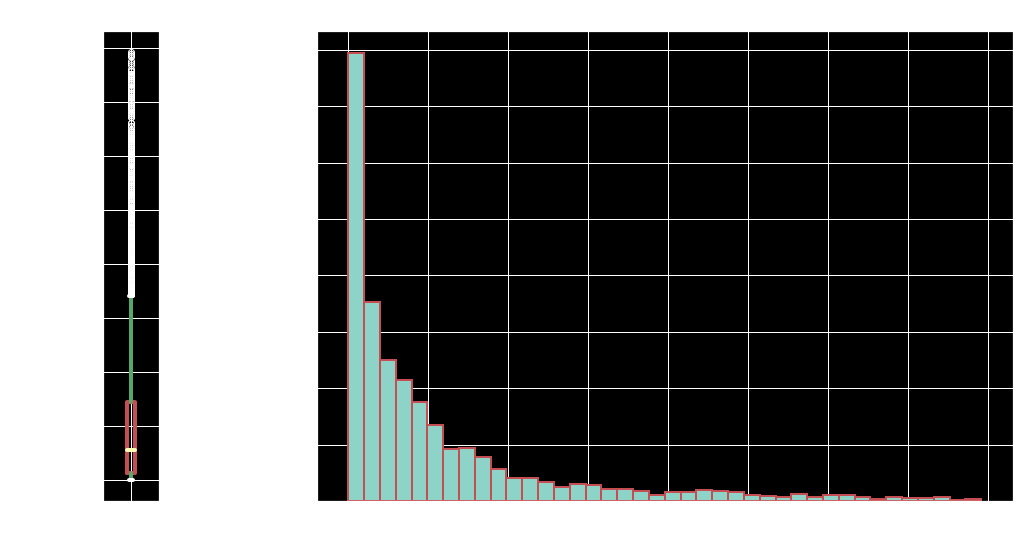

In [20]:

#fig = plt.figure()
fig = plt.figure(figsize=FIGSIZE3)
sns.set(font_scale = (2))
plt.style.use('dark_background')
ax0 = plt.subplot2grid((1,5), (0,0), colspan=1)
ax1 = plt.subplot2grid((1,5), (0,1), colspan=4)
df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS'].plot(kind='box', figsize=LFIGSIZE, ax=ax0, boxprops=dict(linestyle='-', linewidth=4, color='r'), 
                medianprops=dict(linestyle='-', linewidth=4),
                whiskerprops=dict(linestyle='-', linewidth=4, color='g'), 
                capprops=dict(linestyle='-', linewidth=4),)
df_covid_dead_patients_corrected['VAX_TO_DETH_DAYS'].plot(kind='hist', bins=40, figsize=FIGSIZE, edgecolor='r', linewidth=2,ax=ax1)
ax0.set_title('Average Days to Death')
ax1.set_title('VAX to Death Distributtion(Days)')
fig.tight_layout()

## Get daily and weekly VAERS report count data

In [21]:
pd.set_option('display.max_rows', 20)
s=df_covid_patients.groupby(['RECVDATE'])['VAERS_ID'].nunique()
daily_case_count= pd.DataFrame({'DATE': s.index, 'NEW_VAERS_REPORTS': s.values})
#daily_case_count.set_index(['RECVDATE'])
daily_case_count['DATE'] = daily_case_count['DATE'].astype('datetime64[ns]')
#daily_case_count['DATE'] = daily_case_count['DATE'].dt.strftime("%Y/%m/%d")
#daily_case_count['WEEK'] = daily_case_count['DATE'].dt.isocalendar().week

daily_case_count =daily_case_count.sort_values(by='DATE')
daily_case_count.set_index('DATE', inplace=True)
daily_case_count
#weekly_case_count = daily_case_count.resample('w').sum()

,NEW_VAERS_REPORTS
DATE,
2020-12-15,17
2020-12-16,74
2020-12-17,217
2020-12-18,524
2020-12-19,269
...,...
2021-08-16,2799
2021-08-17,1281
2021-08-18,1526


In [22]:
weekly_vaers_reports = daily_case_count.resample('w').sum()
weekly_vaers_reports

,NEW_VAERS_REPORTS
DATE,
2020-12-20,1325
2020-12-27,3692
2021-01-03,7205
2021-01-10,15853
2021-01-17,16078
...,...
2021-07-25,7094
2021-08-01,8525
2021-08-08,8154


## Getting Daily and weekly new VAX admin data


In [23]:
world_covid_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date'])
us_covid_data = world_covid_data[world_covid_data['iso_code']=='USA']
us_covid_data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
110479,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
110480,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
110481,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,0.006,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
110482,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,0.006,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
110483,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,0.015,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111075,USA,North America,United States,2021-09-09,40640499.0,157467.0,146174.857,656666.0,3222.0,1542.429,122074.674,472.995,439.076,1972.473,9.678,4.633,0.99,25869.0,77.705,95608.0,287.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377622065.0,208305270.0,177433044.0,NaN,666933.0,786493.0,112.28,61.94,52.76,NaN,2338.0,NaN,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
111076,USA,North America,United States,2021-09-10,40863868.0,223369.0,144801.143,658992.0,2326.0,1602.286,122745.623,670.949,434.949,1979.460,6.987,4.813,0.97,25622.0,76.963,94505.0,283.871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378569717.0,208704230.0,177899458.0,NaN,947652.0,721844.0,112.56,62.05,52.90,NaN,2146.0,NaN,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN
111077,USA,North America,United States,2021-09-1

In [24]:
us_vax_data = pd.DataFrame()
us_vax_data[['DATE', 'NEW_VAX']] = us_covid_data[['date', 'new_vaccinations']] 
us_vax_data.fillna(0,inplace=True)
us_vax_data = us_vax_data[us_vax_data['NEW_VAX']>0]
us_vax_data.set_index('DATE', inplace=True)
us_vax_data


,NEW_VAX
DATE,
2020-12-21,57909.0
2021-01-05,273209.0
2021-01-06,470328.0
2021-01-07,612621.0
2021-01-08,768813.0
...,...
2021-09-09,666933.0
2021-09-10,947652.0
2021-09-11,902503.0


In [25]:
weekly_us_vax_data = us_vax_data.resample('w').sum()
weekly_us_vax_data.index.rename('WEEK', inplace=True)
weekly_us_vax_data

,NEW_VAX
WEEK,
2020-12-27,57909.0
2021-01-03,0.0
2021-01-10,2124971.0
2021-01-17,3291858.0
2021-01-24,6141067.0
...,...
2021-08-22,6224106.0
2021-08-29,6205963.0
2021-09-05,5625190.0


## Merge weekly Vax data with VAERS report count data

In [26]:
weekly_vaers_reports.index.rename('WEEK', inplace=True)
weekly_vaers_reports


,NEW_VAERS_REPORTS
WEEK,
2020-12-20,1325
2020-12-27,3692
2021-01-03,7205
2021-01-10,15853
2021-01-17,16078
...,...
2021-07-25,7094
2021-08-01,8525
2021-08-08,8154


In [27]:
vax_vs_vaers = pd.merge_asof(weekly_us_vax_data, weekly_vaers_reports, on = 'WEEK', direction = 'nearest' )
vax_vs_vaers.set_index('WEEK', inplace=True)
vax_vs_vaers

,NEW_VAX,NEW_VAERS_REPORTS
WEEK,,
2020-12-27,57909.0,3692
2021-01-03,0.0,7205
2021-01-10,2124971.0,15853
2021-01-17,3291858.0,16078
2021-01-24,6141067.0,15147
...,...,...
2021-08-22,6224106.0,5841
2021-08-29,6205963.0,5841
2021-09-05,5625190.0,5841


##  Introduct Adverse reaction rate

### ADV_ACTION_RATE = #_Of_VAERS_Reports / #_of_VAX_Admined * 100


In [28]:
#vax_vs_vaers = vax_vs_vaers[vax_vs_vaers['WEEK'] != '2021-01-03']
vax_vs_vaers= vax_vs_vaers[vax_vs_vaers.index != '2020-12-27']
vax_vs_vaers= vax_vs_vaers[vax_vs_vaers.index != '2021-01-03']
vax_vs_vaers['ADV_ACTION_RATE'] = round(vax_vs_vaers['NEW_VAERS_REPORTS'] / vax_vs_vaers['NEW_VAX'] * 100, 2)
vax_vs_vaers

,NEW_VAX,NEW_VAERS_REPORTS,ADV_ACTION_RATE
WEEK,,,
2021-01-10,2124971.0,15853,0.75
2021-01-17,3291858.0,16078,0.49
2021-01-24,6141067.0,15147,0.25
2021-01-31,9274644.0,17874,0.19
2021-02-07,10087638.0,15852,0.16
...,...,...,...
2021-08-22,6224106.0,5841,0.09
2021-08-29,6205963.0,5841,0.09
2021-09-05,5625190.0,5841,0.10



<a id='Chart_2'></a>
# Chart 2: New Vaccination and the trend of Adverse Reaction
[index](#index)


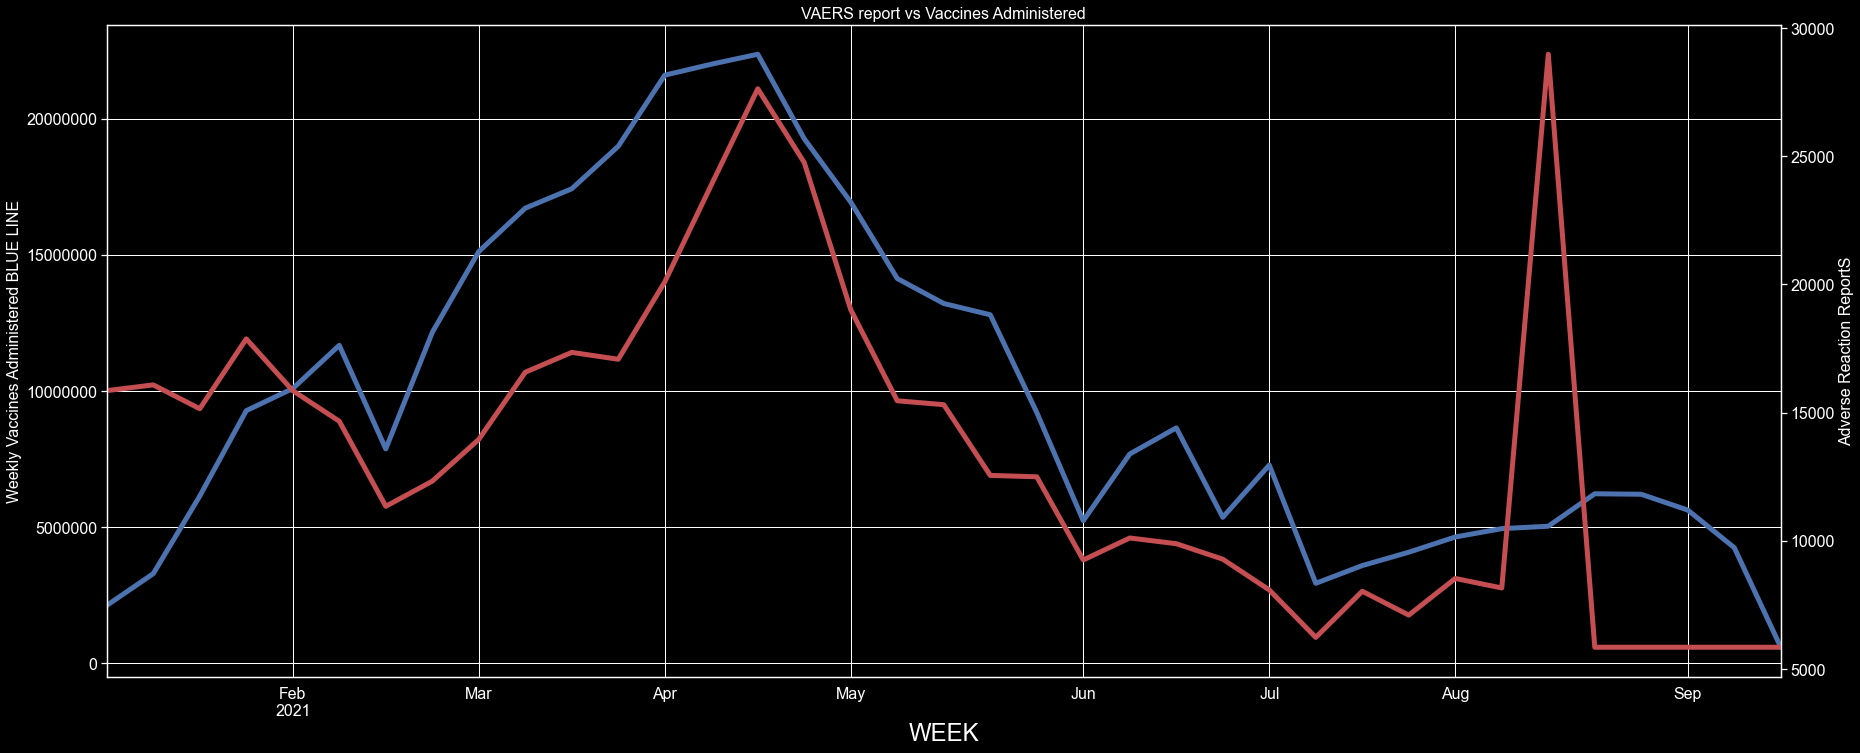

In [29]:
plt.figure(figsize=FIGSIZE3)
ax = vax_vs_vaers['NEW_VAX'].plot(x='WEEK', y='column1', linewidth=5, color='b')
ax.ticklabel_format(style='plain', axis='y')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Weekly Vaccines Administered BLUE LINE', fontsize=16)
ax2 = ax.twinx()
plt.yticks(fontsize=16)
plt.title('VAERS report vs Vaccines Administered', fontsize=16)
plt.ylabel('Adverse Reaction ReportS', fontsize=16)
ax2 = vax_vs_vaers['NEW_VAERS_REPORTS'].plot(x='WEEK', y='column2', ax=ax2, color='r', linewidth=5)
plt.grid(None)
plt.show()


<a id='Chart_3'></a>
# Chart 3: New Vaccination and the trend of Adverse Reaction Rate
[index](#index)


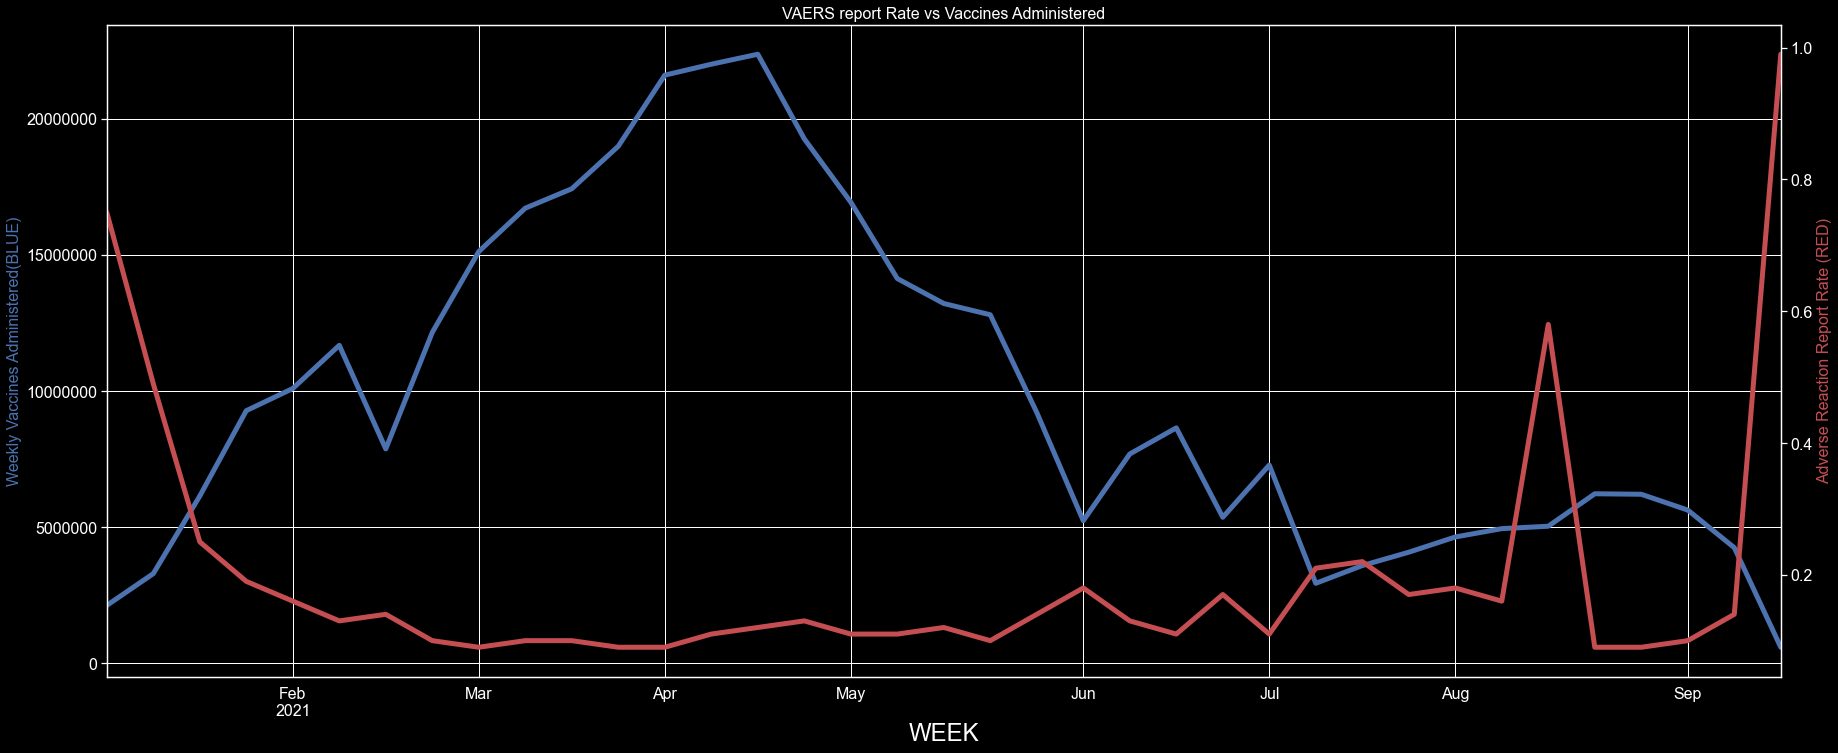

In [30]:
plt.figure(figsize=FIGSIZE3)
ax = vax_vs_vaers['NEW_VAX'].plot(x='WEEK', y='column1', linewidth=5, color='b')
ax.ticklabel_format(style='plain', axis='y')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Weekly Vaccines Administered(BLUE)', fontsize=16, color='b')
ax2 = ax.twinx()
plt.yticks(fontsize=16)
plt.title('VAERS report Rate vs Vaccines Administered', fontsize=16)
plt.ylabel('Adverse Reaction Report Rate (RED)', fontsize=16, color='r')
ax2 = vax_vs_vaers['ADV_ACTION_RATE'].plot(x='WEEK', y='column2', ax=ax2, color='r', linewidth=5)
plt.grid(None)
plt.show()

In [31]:
df_covid_patients = check_duplicates(df_patients)
df_covid_symptoms = check_duplicates(df_symptoms)
df_covid_vax = check_duplicates(df_vax)

Doulicate Rows: 
Empty DataFrame
Columns: [VAERS_ID, RECVDATE, STATE, AGE_YRS, CAGE_YR, CAGE_MO, SEX, RPT_DATE, SYMPTOM_TEXT, DIED, DATEDIED, L_THREAT, ER_VISIT, HOSPITAL, HOSPDAYS, X_STAY, DISABLE, RECOVD, VAX_DATE, ONSET_DATE, NUMDAYS, LAB_DATA, V_ADMINBY, V_FUNDBY, OTHER_MEDS, CUR_ILL, HISTORY, PRIOR_VAX, SPLTTYPE, FORM_VERS, TODAYS_DATE, BIRTH_DEFECT, OFC_VISIT, ER_ED_VISIT, ALLERGIES]
Index: []
Doulicate Rows: 
Empty DataFrame
Columns: [VAERS_ID, SYMPTOM1, SYMPTOMVERSION1, SYMPTOM2, SYMPTOMVERSION2, SYMPTOM3, SYMPTOMVERSION3, SYMPTOM4, SYMPTOMVERSION4, SYMPTOM5, SYMPTOMVERSION5]
Index: []
Doulicate Rows: 
        VAERS_ID VAX_TYPE                     VAX_MANU  VAX_LOT  \
17        855033      UNK         UNKNOWN MANUFACTURER  N010497   
43        855065     FLUX         UNKNOWN MANUFACTURER      NaN   
71        855107   VARZOS  GLAXOSMITHKLINE BIOLOGICALS      NaN   
3863      858939      UNK         UNKNOWN MANUFACTURER      NaN   
4085      860131      UNK         UNKNOWN MANUF

In [32]:
print(df_covid_patients.shape)
print(df_covid_symptoms.shape)
print(df_covid_vax.shape)

(534746, 35)
(709926, 11)
(563780, 8)


In [33]:
# Study table columns
print(df_covid_patients.columns)
print(df_covid_symptoms.columns)
print(df_covid_vax.columns)

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES'],
      dtype='object')
Index(['VAERS_ID', 'SYMPTOM1', 'SYMPTOMVERSION1', 'SYMPTOM2',
       'SYMPTOMVERSION2', 'SYMPTOM3', 'SYMPTOMVERSION3', 'SYMPTOM4',
       'SYMPTOMVERSION4', 'SYMPTOM5', 'SYMPTOMVERSION5'],
      dtype='object')
Index(['VAERS_ID', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')


In [34]:
print(df_covid_patients["VAERS_ID"].nunique())
print(df_covid_symptoms["VAERS_ID"].nunique())
print(df_covid_vax["VAERS_ID"].nunique())



534746
534743
534746


In [35]:
df_covid_patients.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,855017,01/01/2020,HI,55.0,55.0,NaN,F,NaN,"Symptoms occurred almost immediately- aching joints, fever, chills, soreness at injection site - last for 3 days",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/30/2019,12/30/2019,0.0,None,MIL,NaN,Loristan,None,Migraines,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,Morphine
1,855018,01/01/2020,WI,68.0,68.0,NaN,F,NaN,"Extreme pain, muscle weakness in right arm so severe that I could not move my arm, extreme vertigo, tremors throughout body and in hands, fingertip numbness both hands, fever, chills, fatigue, high blood pressure. The walk in clinic doctor thought I was having a stroke (I wasn't).",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/30/2019,12/30/2019,0.0,Same day 12/30/2019. No tests other than routine temperature and blood pressure. Doctor recommended a CT scan and sent me to the emergency room where I declined further treatment.,PHM,NaN,"levothyroxine, multi vitamin, calcium.",None,"Hypothyroidism, Meniere's Disease.",NaN,NaN,2,01/01/2020,NaN,Y,Y,"Penicillin, sulfa drugs, erythromycin, tetracycline, aspirin, cashews, strawberries, raspberries, blackberries."
2,855019,01/01/2020,NaN,50.0,50.0,NaN,F,NaN,SORENESS IN THE AREA. ITCHING AND RASH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/23/2019,12/29/2019,6.0,NaN,UNK,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,NaN
3,855020,01/01/2020,TX,67.0,67.0,NaN,F,NaN,"sore arm, fever 101 , chills, and aching muscles, flu like symptons",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/01/2019,01/01/2020,31.0,none,PHM,NaN,"multi vitamin, calcium, premarin cream",none,none,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,"morphine,"
4,855021,01/01/2020,NaN,73.0,73.0,NaN,F,NaN,"Patient presented to Clinic today 1/1/2020. She reports she received the 2nd dose of her Shingrix vaccine yesterday 12/31/2019 at 12:30 noon at another location. She reports starting yesterday at about 5:30 pm she experienced chills, nausea (no vomiting), intermittent dizziness and racing heart rate when lying down. She denies rash, shortness of breath, chest pain, or trouble swallowing. She denies a similar reaction after getting the first shingrix vaccine. She is allergic to cefzil, clavulanic acid and ofloxacin, and gets GI upset with higher doses of acetaminophen.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2019,12/31/2019,0.0,Temp 99.7 here in clinic. Vital signs WNL otherwise.,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2020,NaN,Y,NaN,NaN


In [36]:
dirty_df_covid_patients = df_covid_patients
dirty_df_covid_symptoms = df_covid_symptoms
dirty_df_covid_vax = df_covid_vax

In [37]:
merged_covid_vaers_data = dirty_df_covid_patients.merge(dirty_df_covid_vax, on = 'VAERS_ID', how = 'inner')
merged_covid_vaers_data = merged_covid_vaers_data.merge(dirty_df_covid_symptoms, on = 'VAERS_ID', how = 'inner')

In [38]:
merged_covid_vaers_data.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,855017,01/01/2020,HI,55.0,55.0,NaN,F,NaN,"Symptoms occurred almost immediately- aching joints, fever, chills, soreness at injection site - last for 3 days",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/30/2019,12/30/2019,0.0,None,MIL,NaN,Loristan,None,Migraines,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,Morphine,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,2,SYR,LA,ZOSTER (SHINGRIX),Arthralgia,22.1,Chills,22.1,Injection site pain,22.1,Pyrexia,22.1,NaN,NaN
1,855018,01/01/2020,WI,68.0,68.0,NaN,F,NaN,"Extreme pain, muscle weakness in right arm so severe that I could not move my arm, extreme vertigo, tremors throughout body and in hands, fingertip numbness both hands, fever, chills, fatigue, high blood pressure. The walk in clinic doctor thought I was having a stroke (I wasn't).",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/30/2019,12/30/2019,0.0,Same day 12/30/2019. No tests other than routine temperature and blood pressure. Doctor recommended a CT scan and sent me to the emergency room where I declined further treatment.,PHM,NaN,"levothyroxine, multi vitamin, calcium.",None,"Hypothyroidism, Meniere's Disease.",NaN,NaN,2,01/01/2020,NaN,Y,Y,"Penicillin, sulfa drugs, erythromycin, tetracycline, aspirin, cashews, strawberries, raspberries, blackberries.",UNK,UNKNOWN MANUFACTURER,NaN,1,IM,RA,VACCINE NOT SPECIFIED (OTHER),Chills,22.1,Fatigue,22.1,Hypertension,22.1,Hypoaesthesia,22.1,Injected limb mobility decreased,22.1
2,855018,01/01/2020,WI,68.0,68.0,NaN,F,NaN,"Extreme pain, muscle weakness in right arm so severe that I could not move my arm, extreme vertigo, tremors throughout body and in hands, fingertip numbness both hands, fever, chills, fatigue, high blood pressure. The walk in clinic doctor thought I was having a stroke (I wasn't).",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/30/2019,12/30/2019,0.0,Same day 12/30/2019. No tests other than routine temperature and blood pressure. Doctor recommended a CT scan and sent me to the emergency room where I declined further treatment.,PHM,NaN,"levothyroxine, multi vitamin, calcium.",None,"Hypothyroidism, Meniere's Disease.",NaN,NaN,2,01/01/2020,NaN,Y,Y,"Penicillin, sulfa drugs, erythromycin, tetracycline, aspirin, cashews, strawberries, raspberries, blackberries.",UNK,UNKNOWN MANUFACTURER,NaN,1,IM,RA,VACCINE NOT SPECIFIED (OTHER),Muscular weakness,22.1,Pain in extremity,22.1,Pyrexia,22.1,Tremor,22.1,Vertigo,22.1
3,855019,01/01/2020,NaN,50.0,50.0,NaN,F,NaN,SORENESS IN THE AREA. ITCHING AND RASH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/23/2019,12/29/2019,6.0,NaN,UNK,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,NaN,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),Pain,22.1,Pruritus,22.1,Rash,22.1,NaN,NaN,NaN,NaN
4,855020,01/01/2020,TX,67.0,67.0,NaN,F,NaN,"sore arm, fever 101 , chills, and aching muscles, flu like symptons",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/01/2019,01/01/2020,31.0,none,PHM,NaN,"multi vitamin, calcium, premarin cream",none,none,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,"morphine,",VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,IM,LA,ZOSTER (SHINGRIX),Chills,22.1,Influenza like illness,22.1,Myalgia,22.1,Pain in extremity,22.1,Pyrexia,22.1


In [39]:
# Check duplicated data
merged_covid_vaers_data[merged_covid_vaers_data.duplicated()]

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5


In [40]:
merged_covid_vaers_data.loc[merged_covid_vaers_data['VAERS_ID'] == 855065 ]

VAERS_ID    RECVDATE STATE  AGE_YRS  CAGE_YR  CAGE_MO SEX RPT_DATE  \
62    855065  01/02/2020    GA      NaN      NaN      NaN   F      NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [41]:
# count of unique value of each column
print(merged_covid_vaers_data.nunique())

VAERS_ID           534743
RECVDATE              598
STATE                  71
AGE_YRS               156
CAGE_YR               115
                    ...  
SYMPTOMVERSION3         4
SYMPTOM4             5307
SYMPTOMVERSION4         4
SYMPTOM5             4886
SYMPTOMVERSION5         4
Length: 52, dtype: int64


In [42]:

print(merged_covid_vaers_data['VAERS_ID'].value_counts())

857320     60
985686     56
872512     52
887723     44
1019670    42
           ..
1103061     1
1103060     1
1103059     1
1103058     1
1177933     1
Name: VAERS_ID, Length: 534743, dtype: int64


In [43]:
merged_covid_vaers_data[merged_covid_vaers_data['VAERS_ID']==857320]

VAERS_ID    RECVDATE STATE  AGE_YRS  CAGE_YR  CAGE_MO SEX RPT_DATE  \
2856    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2857    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2858    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2859    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2860    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
...        ...         ...   ...      ...      ...      ...  ..      ...   
2911    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2912    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2913    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2914    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   
2915    857320  01/20/2020    HI     18.0     18.0      NaN   M      NaN   

                                                                                         SYMPTOM_TEXT  \
2856  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2857  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2858  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2859  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2860  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
...                                                                                               ...   
2911  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2912  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2913  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2914  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   
2915  myalgias, decreased range of motion, chest pain, rhabdoymyolysis with creatinine kinase >20,000   

     DIED DATEDIED L_THREAT ER_VISIT HOSPITAL  HOSPDAYS X_STAY DISABLE RECOVD  \
2856  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2857  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2858  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2859  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2860  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
...   ...      ...      ...      ...      ...       ...    ...     ...    ...   
2911  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2912  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2913  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2914  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   
2915  NaN      NaN        Y      NaN        Y       2.0    NaN     NaN      Y   

        VAX_DATE  ONSET_DATE  NUMDAYS  \
2856  01/14/2020  01/15/2020      1.0   
2857  01/14/2020  01/15/2020      1.0   
2858  01/14/2020  01/15/2020      1.0   
2859  01/14/2020  01/15/2020      1.0   
2860  01/14/2020  01/15/2020      1.0   
...          ...         ...      ...   
2911  01/14/2020  01/15/2020      1.0   
2912  01/14/2020  01/15/2020      1.0   
2913  01/14/2020  01/15/2020      1.0   
2914  01/14/2020  01/15/2020      1.0   
2915  01/14/2020  01/15/2020      1.0   

                                                                                                                                                                                                                                                                                                                                                                              

In [44]:
df_covid_vax[df_covid_vax['VAERS_ID']==857320]

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
2229,857320,ANTH,EMERGENT BIOSOLUTIONS,300031A,5,IM,NaN,ANTHRAX (BIOTHRAX)
2230,857320,FLU4,SANOFI PASTEUR,P100122537,NaN,IM,NaN,INFLUENZA (SEASONAL) (FLUZONE INTRADERMAL QUADRIVALENT)
2231,857320,JEV1,INTERCELL AG,JEV18G82E,2,IM,NaN,JAPANESE ENCEPHALITIS (IXIARO)
2232,857320,MMR,MERCK & CO. INC.,NaN,3,NaN,NaN,MEASLES + MUMPS + RUBELLA (MMR II)
2233,857320,VARCEL,MERCK & CO. INC.,NaN,2,NaN,NaN,VARICELLA (VARIVAX)


In [45]:
df_covid_symptoms[df_covid_symptoms['VAERS_ID']==857320]

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
2321,857320,Activated partial thromboplastin time normal,22.1,Alanine aminotransferase increased,22.1,Anion gap,22.1,Aspartate aminotransferase increased,22.1,Basophil count decreased,22.1
2322,857320,Basophil percentage decreased,22.1,Blood albumin normal,22.1,Blood alkaline phosphatase normal,22.1,Blood bicarbonate normal,22.1,Blood bilirubin normal,22.1
2323,857320,Blood calcium normal,22.1,Blood chloride increased,22.1,Blood creatine phosphokinase increased,22.1,Blood creatinine normal,22.1,Blood glucose normal,22.1
2324,857320,Blood potassium normal,22.1,Blood sodium normal,22.1,Blood urea normal,22.1,Blood urine present,22.1,C-reactive protein normal,22.1
2325,857320,Chest pain,22.1,Chromaturia,22.1,Eosinophil count decreased,22.1,Eosinophil percentage,22.1,Glomerular filtration rate,22.1
2326,857320,Glucose urine absent,22.1,Granulocyte percentage,22.1,Haematocrit normal,22.1,Haemoglobin normal,22.1,International normalised ratio increased,22.1
2327,857320,Joint range of motion decreased,22.1,Lymphocyte count decreased,22.1,Lymphocyte percentage decreased,22.1,Mean cell haemoglobin concentration normal,22.1,Mean cell haemoglobin normal,22.1
2328,857320,Mean cell volume normal,22.1,Mean platelet volume normal,22.1,Monocyte count increased,22.1,Monocyte percentage increased,22.1,Myalgia,22.1
2329,857320,Neutrophil count normal,22.1,Nitrite urine absent,22.1,Platelet count normal,22.1,Protein total normal,22.1,Protein urine absent,22.1
2330,857320,Prothrombin time prolonged,22.1,Red blood cell count normal,22.1,Red blood cell sedimentation rate normal,22.1,Red blood cells urine negative,22.1,Red cell distribution width normal,22.1


In [46]:
# Change text data to upper cases
merged_covid_vaers_data= merged_covid_vaers_data.applymap(lambda s:s.upper() if type(s) == str else s)

In [47]:
merged_covid_vaers_data['SYMPTOM_TEXT']

0                                                                                                                                                                                              SYMPTOMS OCCURRED ALMOST IMMEDIATELY- ACHING JOINTS, FEVER, CHILLS, SORENESS AT INJECTION SITE - LAST FOR 3 DAYS
1                     EXTREME PAIN, MUSCLE WEAKNESS IN RIGHT ARM SO SEVERE THAT I COULD NOT MOVE MY ARM, EXTREME VERTIGO, TREMORS THROUGHOUT BODY AND IN HANDS, FINGERTIP NUMBNESS BOTH HANDS, FEVER, CHILLS, FATIGUE, HIGH BLOOD PRESSURE. THE WALK IN CLINIC DOCTOR THOUGHT I WAS HAVING A STROKE (I WASN'T).
2                     EXTREME PAIN, MUSCLE WEAKNESS IN RIGHT ARM SO SEVERE THAT I COULD NOT MOVE MY ARM, EXTREME VERTIGO, TREMORS THROUGHOUT BODY AND IN HANDS, FINGERTIP NUMBNESS BOTH HANDS, FEVER, CHILLS, FATIGUE, HIGH BLOOD PRESSURE. THE WALK IN CLINIC DOCTOR THOUGHT I WAS HAVING A STROKE (I WASN'T).
3                                                                                       

# Report functions



In [48]:
def ana_disease(df : pd.DataFrame, disease : str, bins : int):
    NO_OF_BINS=bins
    df_disease = df[df.eq(disease.upper()).any(1)]
    #print(df_disease.head())
    #print(df_disease['VAERS_ID'].duplicated())
    df_chart = df_disease[['VAERS_ID', 'AGE_YRS']]
    df_chart.drop_duplicates()
    fig = plt.figure()
    sns.set(font_scale = (2))
    plt.style.use('dark_background')
    ax0 = plt.subplot2grid((1,5), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,5), (0,1), colspan=4)
    df_chart['AGE_YRS'].plot(kind='box', figsize=LFIGSIZE, ax=ax0, boxprops=dict(linestyle='-', linewidth=4, color='r'), 
                    medianprops=dict(linestyle='-', linewidth=4),
                    whiskerprops=dict(linestyle='-', linewidth=4, color='g'), 
                    capprops=dict(linestyle='-', linewidth=4),)
    df_chart['AGE_YRS'].plot(kind='hist', bins=NO_OF_BINS, figsize=FIGSIZE, edgecolor='r', linewidth=2,ax=ax1)
    ax0.set_title('Average Age')
    ax1.set_title( disease.capitalize() + ' Reactions by Age')
    fig.tight_layout()


<a id='Chart_4'></a>
# Chart 4: Cancer Reaction by Age
[index](#index)

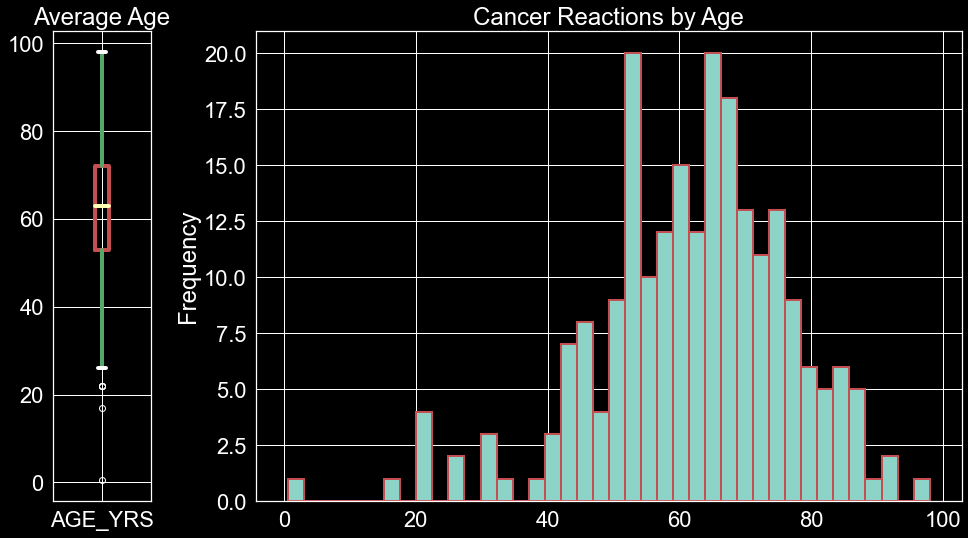

In [49]:
ana_disease(merged_covid_vaers_data, 'CANCER', 40)


<a id='Chart_5'></a>
# Chart 5: Myocarditis Reaction by Age
[index](#index)

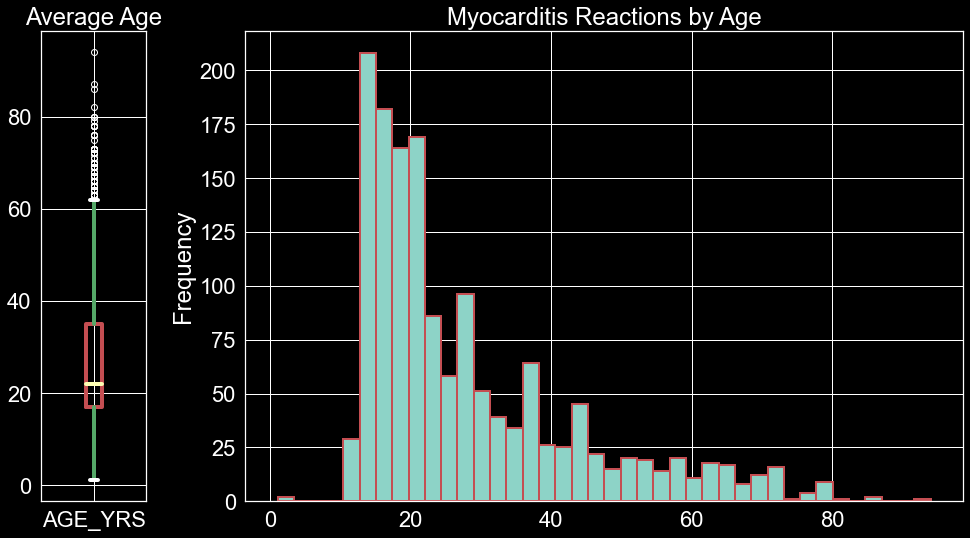

In [50]:
ana_disease(merged_covid_vaers_data, 'MYOCARDITIS', 40)

# Disease group analysis

In [51]:
def ana_diseasegroup(df : pd.DataFrame, disease_group : list, bins : int):
    NO_OF_BINS=bins
    disease_group = [ each_string.upper() for each_string in disease_group ]
    df_disease = df[df.isin(disease_group).any(1)]
    #print(df_disease.head())
    #print(df_disease['VAERS_ID'].duplicated())
    df_chart = df_disease[['VAERS_ID', 'AGE_YRS']]
    df_chart.drop_duplicates()
    fig = plt.figure()
    sns.set(font_scale = (2))
    plt.style.use('dark_background')
    ax0 = plt.subplot2grid((1,5), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,5), (0,1), colspan=4)
    df_chart['AGE_YRS'].plot(kind='box', figsize=LFIGSIZE, ax=ax0, boxprops=dict(linestyle='-', linewidth=4, color='r'), 
                    medianprops=dict(linestyle='-', linewidth=4),
                    whiskerprops=dict(linestyle='-', linewidth=4, color='g'), 
                    capprops=dict(linestyle='-', linewidth=4),)
    df_chart['AGE_YRS'].plot(kind='hist', bins=NO_OF_BINS, figsize=FIGSIZE, edgecolor='r', linewidth=2,ax=ax1)
    ax0.set_title('Average Age')
    ax1.set_title( 'Reactions by Age')
    fig.tight_layout()

<a id='Chart_6'></a>
# Chart 6: Blook Clots Reaction by Age
[index](#index)

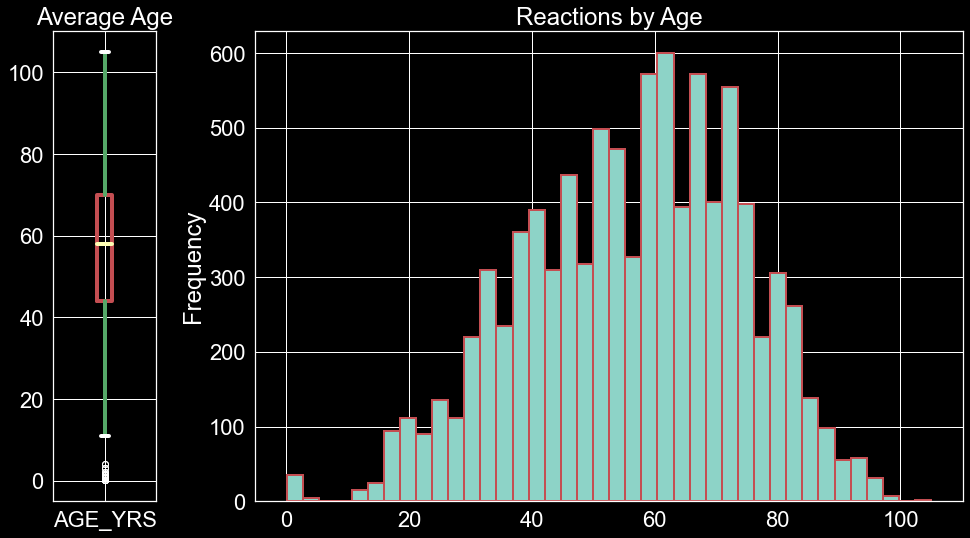

In [52]:
Blood_Clots = [
"Pulmonary embolism", 
"Thrombosis", 
"Deep vein thrombosis", 
"Anticoagulant therapy", 
"Thrombocytopenia", 
"Pulmonary thrombosis", 
"Immune thrombocytopenia", 
"Prothrombin time", 
"Thrombectomy", 
"Thrombophlebitis superficial", 
"Cerebral venous sinus thrombosis", 
"Cerebral thrombosis", 
"Portal vein thrombosis"
] 
ana_diseasegroup(merged_covid_vaers_data, Blood_Clots, 40)